In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

D:\tanay\anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\tanay\anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data = pd.concat([train.drop('SalePrice',axis=1),test])

In [4]:
data.shape

(2919, 80)

In [5]:
y = np.log1p(train.SalePrice)

In [6]:
num = data.dtypes[data.dtypes !='object'].index

In [7]:
skew = data[num].apply(lambda x: skew(x.dropna()))

In [8]:
skew = skew[skew > 0.75].index

In [9]:
lst = [x for x in skew]

In [10]:
for i in skew:
    data[i] = np.log1p(data[i])

In [11]:
#data.MSZoning

In [12]:
na = data.isna().sum().sort_values(ascending = False)
na = na[na >0]

In [13]:
for c in na[1:].index:
   data[c] = data[c].fillna(data[c].mode()[0])


In [14]:
col = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageQual','GarageFinish','GarageType',
      'BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1','MasVnrType']
data[col] = data[col].fillna('None')

In [15]:
col2 = ['GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','BsmtFinSF1','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2',
       'GarageCars','GarageArea']
data[col2] = data[col2].fillna(0)

In [16]:
data["LotFrontage"] = data.groupby('LotConfig')["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [17]:
data = pd.get_dummies(data)

In [18]:
X_train =data[:train.shape[0]]
X_test = data[train.shape[0]:]
y = np.log1p(train.SalePrice)

In [23]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
np.min(cv_ridge)

0.12708663729090813

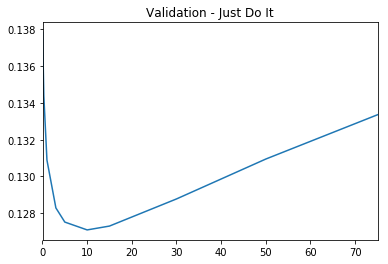

In [20]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")

In [32]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv = 5).fit(X_train, y)
rmse_cv(lasso).mean()

0.12275747208487875

In [33]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=360, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [34]:
rmse_cv(model_xgb).mean()

0.12456439596533472

In [36]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(lasso.predict(X_test))

In [37]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [38]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)